Semaglutide is a new (glucagon-like peptide-1) GLP-1 agonist, used to treat diabetes. It is used weekely and can be used in place of duaglutide which is a very similar medicine that has been around for awhile. Both preparations are used weekly but duaglutide is a single use injector i.e. you need one box of four injectors for a month and Semaglutide comes as a pen injector with four doses i.e. you need one pen for one month.

We have heard reports that prescribers are prescribing excess quantities of semaglutide. This note book sets out to check 
a) are prescribers prescribing excess Semaglutide due to confusion related to 4 doses being in one pen
b) are EHRs having an effect based on the way the information is presented to prescribers. 

In [1]:

##importing libraries
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sql = '''
SELECT
  CAST(month AS DATE) AS month,
  pct,
  SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END) AS four,
  SUM(total_quantity) AS total_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_four
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
hscic.ccgs AS ccgs
ON
presc.pct=ccgs.code
WHERE
(bnf_code LIKE "0601023AW%") ##semaglutide
AND
ccgs.org_type='CCG'
GROUP BY
  month,
  pct
ORDER BY
  percent_four DESC
    '''

df = bq.cached_read(sql, csv_path='df_sema_qty.csv')
df['month'] = df['month'].astype('datetime64[ns]')
df.head()

,month,pct,four,total_QI,percent_four
0,2019-08-01,08K,8,8,1.0
1,2019-08-01,11J,4,4,1.0
2,2019-06-01,01T,4,4,1.0
3,2019-06-01,07W,4,4,1.0
4,2019-04-01,08N,16,16,1.0


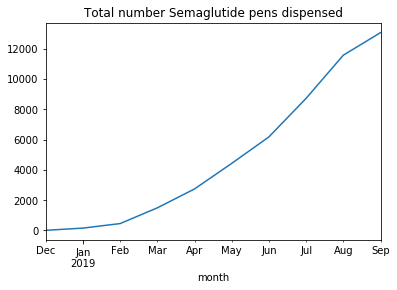

In [3]:
df.groupby("month")['total_QI'].sum().plot(kind='line', title="Total number Semaglutide pens dispensed")

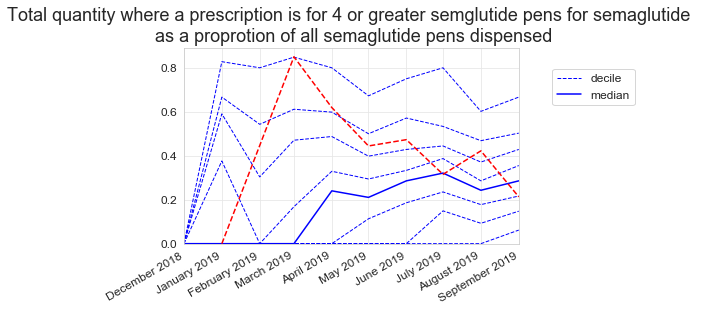

In [4]:
##here we chart a measure of semaglutide quantity of 4

charts.deciles_chart(
        df,
        period_column='month',
        column='percent_four',
        title="Total quantity where a prescription is for 4 or greater semglutide pens for semaglutide \n as a proprotion of all semaglutide pens dispensed",
        show_outer_percentiles=False)

#add in example CCG (Devon - 15N)
df_subject = df.loc[df['pct'] == '15N'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['percent_four'], 'r--')

plt.show()

### EHR

In [5]:
sql = """
SELECT
rx.month,
TRIM(Principal_Supplier) AS supplier,
    SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END) AS four,
  SUM(total_quantity) AS total_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item>=4 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_four
FROM
ebmdatalab.hscic.raw_prescribing_normalised AS rx
JOIN
  alex.vendors AS software
ON
  software.ODS = rx.practice
  AND date(software.Date) = date(rx.month)
WHERE
bnf_code LIKE "0601023AW%" ##semglutide
GROUP BY
rx.month,
supplier
ORDER BY
month"""

df_ehr_sema = bq.cached_read(sql, csv_path='df_ehr_sema.csv')
df_ehr_sema['month'] = df_ehr_sema['month'].astype('datetime64[ns]')
df_ehr_sema.head(3)

,month,supplier,four,total_QI,percent_four
0,2018-12-01,EMIS,0,2,0.000000
1,2019-01-01,Vision,4,8,0.500000
2,2019-01-01,EMIS,32,77,0.415584


Text(0.5,1,'total semaglutide pens per EHR vendor')

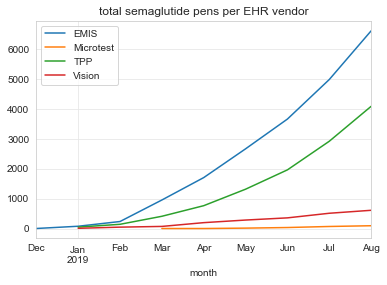

In [6]:
df_ehr_sema.groupby(['month', 'supplier']).sum()['total_QI'].unstack().plot.line()
plt.legend(loc='best')
plt.title("total semaglutide pens per EHR vendor")

Text(0.5,1,'tTotal quantity where a prescription is for 4 or greater semglutide pens for semaglutide \n as a proprotion of all semaglutide pens dispensed')

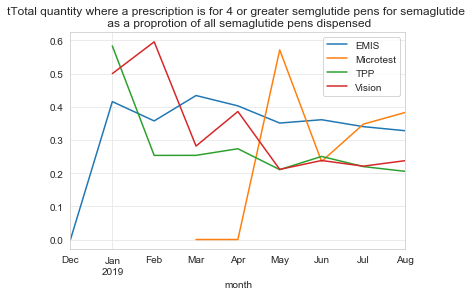

In [7]:
df_ehr_sema.groupby(['month', 'supplier']).sum()['percent_four'].unstack().plot.line()
plt.legend(loc='best')
plt.title("tTotal quantity where a prescription is for 4 or greater semglutide pens for semaglutide \n as a proprotion of all semaglutide pens dispensed")

This numbers are probably too low to detect anything meaningful however we should revisist questions like this if we obtain funding to do substantial work on EHR design.

## Conclusion thus far

Prescribers are getting confused with Semaglutide which confirms feedback we have gotten. We should probably look at prescribing in multiples of 4 to really isolate a true error e.g. 8 etc and remove quantities like 2,3,5 where it is more likely to be an active decision by a prescriber. WE should share with colleagues and write a measure following some more feedback.